# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">1 hr</span>
* 2. Part B: <span style="color:red;">3 hrs</span>
* 3. Part C: <span style="color:red;">2 hrs</span>
* 4. Part D: <span style="color:red;">3 hrs</span>
* 5. Write-up: <span style="color:red;">10 minutes</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

## Part A Code

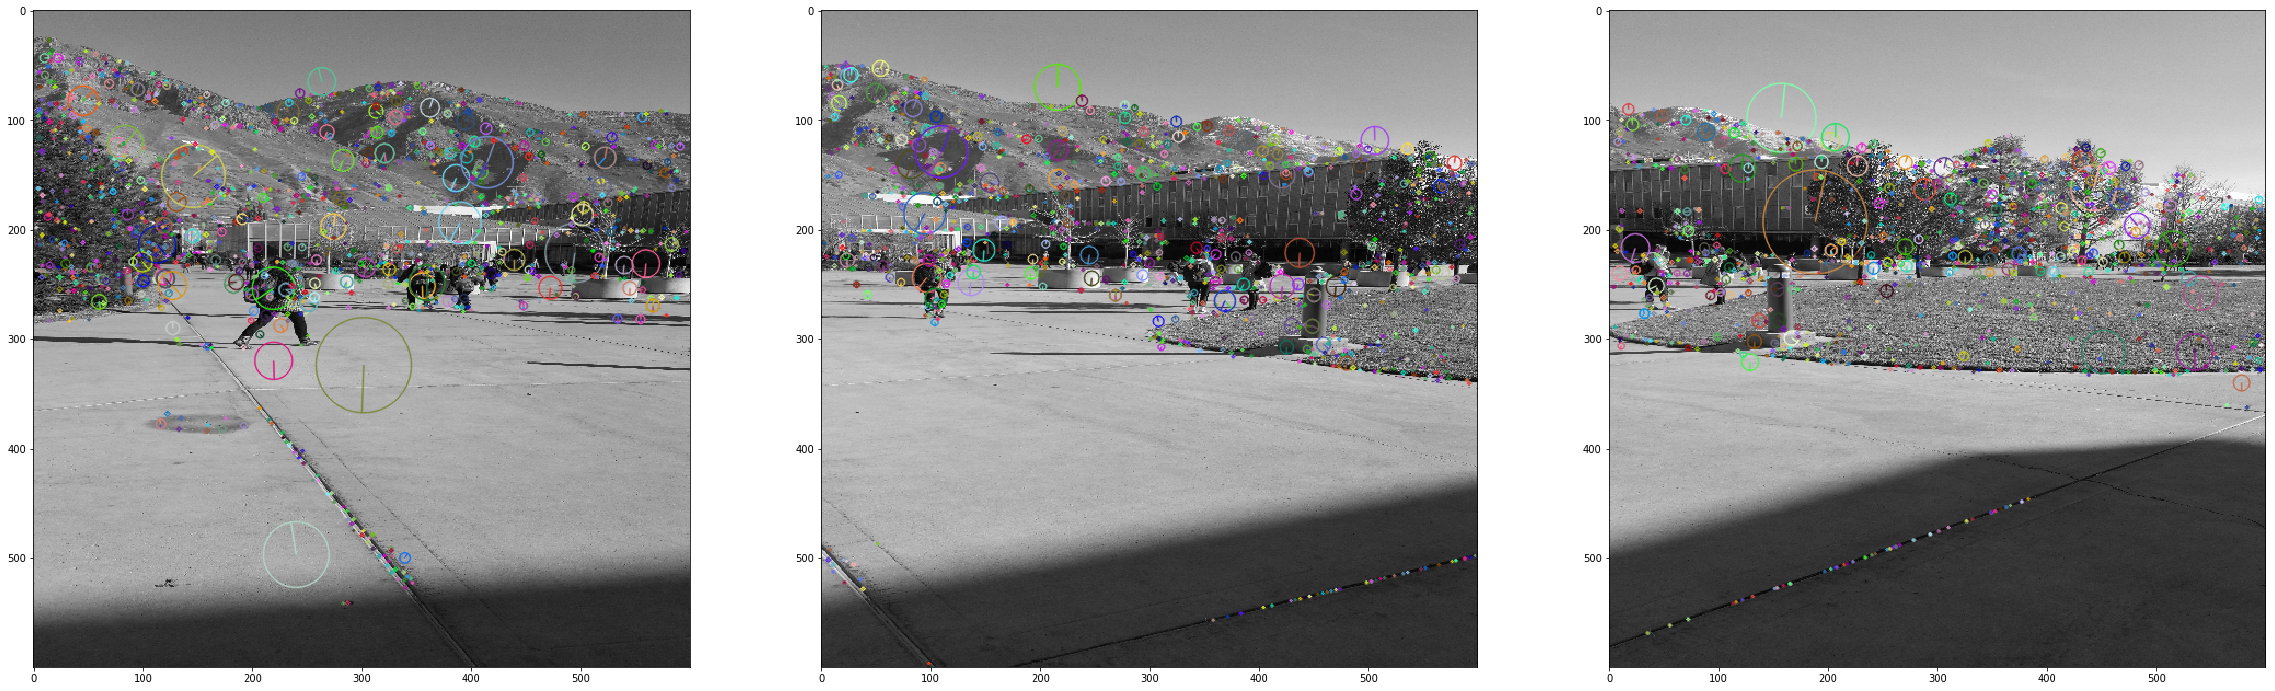

In [127]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random as rand

def plotImage(image, subplot):
    plt.rcParams['figure.figsize'] = [40,22]
    plt.rcParams['axes.titlesize'] = '16'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.subplot(subplot)
    plt.imshow(image, cmap='gray')

def openResizeImage(path):
    image = cv.imread(path)
    image = image[:,:,::-1]
    resized = cv.resize(image, (600,600))
    return resized
    
def openResizeGrayImage(path):
    image = cv.imread(path, cv.IMREAD_GRAYSCALE)
#     image = image[:,:,::-1]
#     gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    resized = cv.resize(image, (600,600))
    return resized

def getDescriptorsImage(gray):
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    img=cv.drawKeypoints(gray,kp,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

def getDescriptors(gray):
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    return kp,des

#----------------Show descriptor circles-------------------#
gray1 = openResizeGrayImage("./Images/campus1.jpg")
image1 = getDescriptorsImage(gray1)
plotImage(image1, 131)

gray3 = openResizeGrayImage("./Images/campus3.jpg")
image3 = getDescriptorsImage(gray3)
plotImage(image3, 132)

gray2 = openResizeGrayImage("./Images/campus2.jpg")
image2 = getDescriptorsImage(gray2)
plotImage(image2, 133)

color1 = openResizeImage("./Images/campus1.jpg")
color2 = openResizeImage("./Images/campus2.jpg")
color3 = openResizeImage("./Images/campus3.jpg")

plt.show()

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

## Part B Code

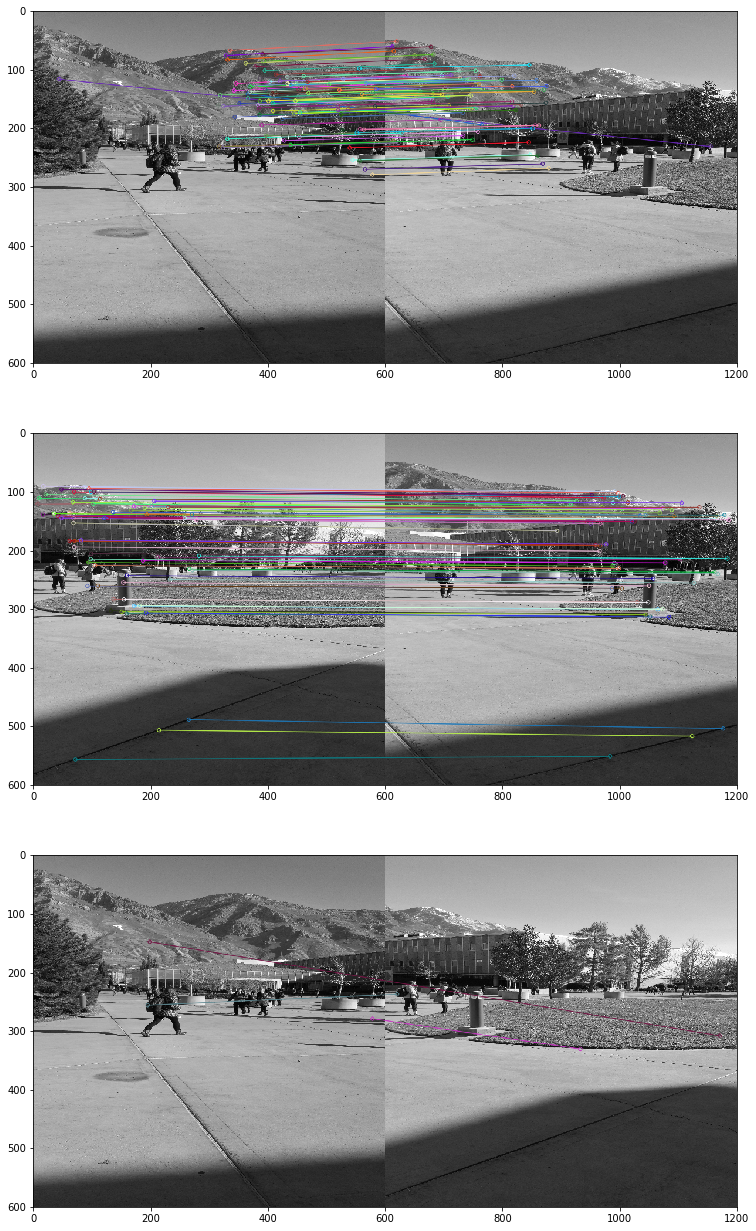

In [128]:
#image 1 is query, image 2 is training
def putativeMatches(kp1, kp2, des1, des2):    
    #spot (2,3) is the distance from des1[2] to des2[3]
    distMatrix = np.zeros((len(kp1), len(kp2)), dtype=float)
    
    #for each descriptor of image 1
    for row1 in range(len(des1)):
        #for each descriptor of image 2
        for row2 in range(len(des2)):
            #calculate euclidian distance between row1 descriptor and row2 descriptor
            euclidDistance = cv.norm(des1[row1], des2[row2], normType=cv.NORM_L2)
            distMatrix[row1][row2] = euclidDistance
        
    #small distance is good, find the mins
    bestMatches = []
    
    #for each row of distMatrix (so each row for des1)
    for row in range(len(distMatrix)):
        #find minimum of row to whatever column, save that column index
        minCol = np.argmin(distMatrix[row])
        
        #get the minRow index for that column
        minRow = np.argmin(distMatrix[:, minCol])
        
        #if the minRow index matches the row we're on, it's a putative match
        if minRow == row:
            bestDist = distMatrix[row,minCol]
            
            #do ratio test with second mins
            #find the row's second min
            secondBestDistRow = np.sort(distMatrix[row])[1]
            
            #does it pass the ratio test for the row?
            if (bestDist / secondBestDistRow) < 0.75:
                
                #ratio test for column
                secondBestDistCol = np.sort(distMatrix[:, minCol])[1]
                if (bestDist / secondBestDistCol) < 0.75:
                    #it passed both ratio tests
                    #Append a new dmatch obj to bestMatches
                    bestMatches.append(cv.DMatch(row, minCol, bestDist))
    return bestMatches

kp1, des1 = getDescriptors(gray1)
kp3, des3 = getDescriptors(gray3)
kp2, des2 = getDescriptors(gray2)

matches13 = putativeMatches(kp1, kp3, des1, des3)
img13 = cv.drawMatches(gray1,kp1,gray3,kp3,matches13,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plotImage(img13, 311)

matches23 = putativeMatches(kp2, kp3, des2, des3)
img23 = cv.drawMatches(gray2,kp2,gray3,kp3,matches23,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plotImage(img23, 312)

matches12 = putativeMatches(kp1, kp2, des1, des2)
img12 = cv.drawMatches(gray1,kp1,gray2,kp2,matches12,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plotImage(img12, 313)

plt.show()

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

## Part C Code

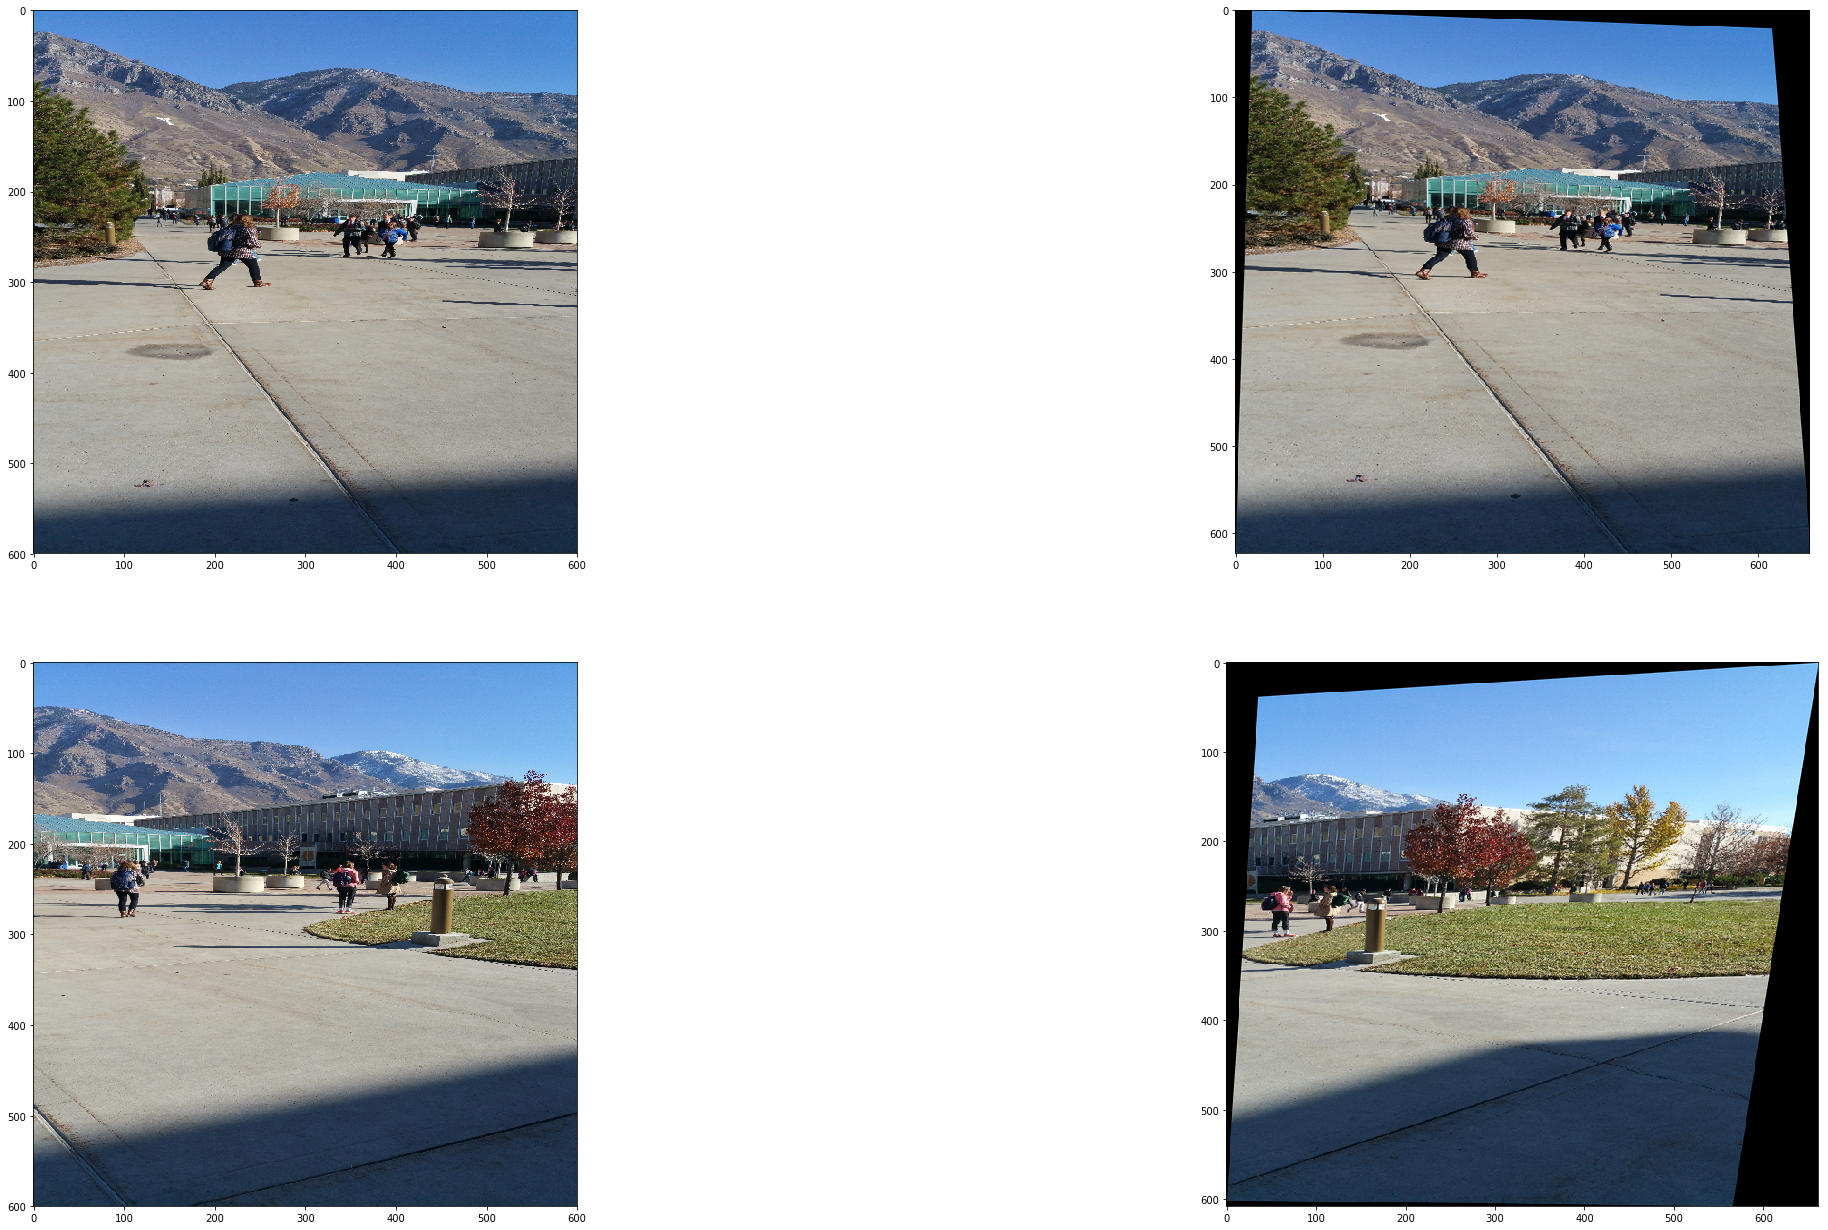

In [129]:
#returns a bad-A transformation matrix
def estimateHomography(matches, kp1, kp2):    
    numLoops = 100 #used to be 72, I wanted better accuracy
    winningHomography = np.zeros((3,3), dtype=float)
    bestConsensus = 0
    minDistanceRequired = 12
    i = 0
    
    #if there aren't 4 matches, just return
    if len(matches) < 4:
        print("There were only ", len(matches), " matches, no homography computed.")
        return None
    
    while i < numLoops:
        #grab four random pairs of points
        fourPairs = rand.sample(matches, 4)
        
        #A is the first matrix of slide 20 with all the x and y values
        A = np.zeros((8,8), dtype=float)
        
        #fill in the first matrix with the xy points and stuff
        x1 = kp1[fourPairs[0].queryIdx].pt[0]
        y1 = kp1[fourPairs[0].queryIdx].pt[1]
        x1p = kp2[fourPairs[0].trainIdx].pt[0]
        y1p = kp2[fourPairs[0].trainIdx].pt[1]
        
        x2 = kp1[fourPairs[1].queryIdx].pt[0]
        y2 = kp1[fourPairs[1].queryIdx].pt[1]
        x2p = kp2[fourPairs[1].trainIdx].pt[0]
        y2p = kp2[fourPairs[1].trainIdx].pt[1]
        
        x3 = kp1[fourPairs[2].queryIdx].pt[0]
        y3 = kp1[fourPairs[2].queryIdx].pt[1]
        x3p = kp2[fourPairs[2].trainIdx].pt[0]
        y3p = kp2[fourPairs[2].trainIdx].pt[1]
        
        x4 = kp1[fourPairs[3].queryIdx].pt[0]
        y4 = kp1[fourPairs[3].queryIdx].pt[1]
        x4p = kp2[fourPairs[3].trainIdx].pt[0]
        y4p = kp2[fourPairs[3].trainIdx].pt[1]
        
        A[0,0] = x1
        A[0,1] = y1
        A[0,2] = 1
        A[0,6] = (-x1p * x1)
        A[0,7] = (-x1p * y1)
        
        A[1,3] = x1
        A[1,4] = y1
        A[1,5] = 1
        A[1,6] = (-y1p * x1)
        A[1,7] = (-y1p * y1)
        
        A[2,0] = x2
        A[2,1] = y2
        A[2,2] = 1
        A[2,6] = (-x2p * x2)
        A[2,7] = (-x2p * y2)
        
        A[3,3] = x2
        A[3,4] = y2
        A[3,5] = 1
        A[3,6] = (-y2p * x2)
        A[3,7] = (-y2p * y2)
        
        A[4,0] = x3
        A[4,1] = y3
        A[4,2] = 1
        A[4,6] = (-x3p * x3)
        A[4,7] = (-x3p * y3)
        
        A[5,3] = x3
        A[5,4] = y3
        A[5,5] = 1
        A[5,6] = (-y3p * x3)
        A[5,7] = (-y3p * y3)
        
        A[6,0] = x4
        A[6,1] = y4
        A[6,2] = 1
        A[6,6] = (-x4p * x4)
        A[6,7] = (-x4p * y4)
        
        A[7,3] = x4
        A[7,4] = y4
        A[7,5] = 1
        A[7,6] = (-y4p * x4)
        A[7,7] = (-y4p * y4)
        
                
        #B is the third matrix of slide 20 with the x and y primes
        B = np.zeros((8,1), dtype=float)
        B[0,0] = x1p
        B[1,0] = y1p
        B[2,0] = x2p
        B[3,0] = y2p
        B[4,0] = x3p
        B[5,0] = y3p
        B[6,0] = x4p
        B[7,0] = y4p
        
        #Compute the homography 
        try:
            X = np.linalg.solve(A, B)
        except np.linalg.LinAlgError as err:
            continue

        #reshape x into 3x3
        H = np.zeros((3,3), dtype=float)
        H[0,0] = X[0,0]
        H[0,1] = X[1,0]
        H[0,2] = X[2,0]
        
        H[1,0] = X[3,0]
        H[1,1] = X[4,0]
        H[1,2] = X[5,0]
        
        H[2,0] = X[6,0]
        H[2,1] = X[7,0]
        H[2,2] = 1
        #apply the homography and see how many points match
        consensusCount = 0
        
        for match in matches:
            pt1 = np.zeros((3,1), dtype=float)
            pt1[0,0] = kp1[match.queryIdx].pt[0]
            pt1[1,0] = kp1[match.queryIdx].pt[1]
            pt1[2,0] = 1
            
            pt2 = np.zeros((3,1), dtype=float)
            pt2[0,0] = kp2[match.trainIdx].pt[0]
            pt2[1,0] = kp2[match.trainIdx].pt[1]
            pt2[2,0] = 1
            projectedPoint = np.matmul(H, pt1)
            
            #see if the projected point and pt2 are close enough in distance
            euclidDistance = cv.norm(projectedPoint, pt2, normType=cv.NORM_L2)
            if euclidDistance < minDistanceRequired:
                #it matched
                consensusCount += 1
        
        #see if it's a new high
        if consensusCount > bestConsensus:
            bestConsensus = consensusCount
            winningHomography = H
        i += 1
    return winningHomography

def warpImage(img, homography):
    # Find the corners after the transform has been applied
    height, width = img.shape[:2]
    corners = np.array([
      [0, 0],
      [0, height - 1],
      [width - 1, height - 1],
      [width - 1, 0]
    ])
    corners = cv.perspectiveTransform(np.float32([corners]), homography)[0]
    
    # Find the bounding rectangle
    bx, by, bwidth, bheight = cv.boundingRect(corners)
    
    # Compute the translation homography that will move (bx, by) to (0, 0)
    th = np.array([
      [ 1, 0, -bx],
      [ 0, 1, -by],
      [ 0, 0,   1 ]
    ])
    
    # Combine the homographies
    pth = th.dot(homography)
    
    # Apply the transformation to image
    warped = cv.warpPerspective(img, pth, (bwidth, bheight), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)
    return warped, bx, by, bwidth, bheight

homography13 = estimateHomography(matches13, kp1, kp3)
homography23 = estimateHomography(matches23, kp2, kp3)
warped13, bx13, by13, bwidth13, bheight13 = warpImage(color1, homography13)
warped23, bx23, by23, bwidth23, bheight23 = warpImage(color2, homography23)

plotImage(color1, 221)
plotImage(warped13, 222)
plotImage(color3, 223)
plotImage(warped23, 224)
plt.show()

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

## Part D Code and Final Results

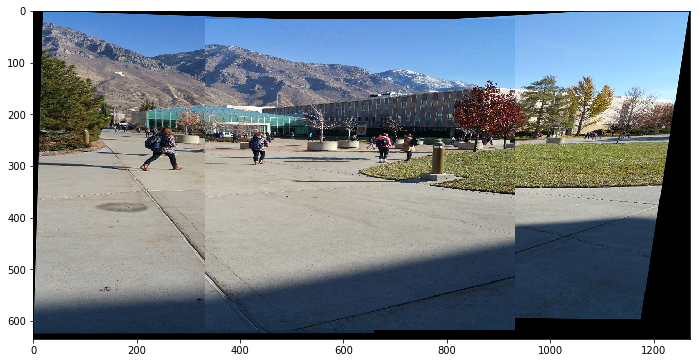

In [130]:
#lets goooo!!!
def combineImages(color1, homography13, bx13, by13, bwidth13, bheight13,
                  color2, homography23, bx23, by23, bwidth23, bheight23,
                  color3):
    topRightCornerOfRightX = bx23 + bwidth23
    masterWidth = abs(bx13) + topRightCornerOfRightX
    highestYPoint = by13
    if by23 < highestYPoint:
        highestYPoint = by23
    
    lowestYPoint = by13 + bheight13
    if by23 + bheight23 > lowestYPoint:
        lowestYPoint = by23 + bheight23
    
    masterHeight = abs(highestYPoint) + abs(lowestYPoint)
    
    offset = np.zeros((3,3), dtype=float)
    offset[0,0] = 1
    offset[0,2] = -bx13
    offset[1,1] = 1
    offset[1,2] = -by13
    offset[2,2] = 1 
    
    pth13 = offset.dot(homography13)
    pth23 = offset.dot(homography23)
    
    centerImg = cv.warpPerspective(color3, offset, (masterWidth, masterHeight), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)
    leftImg = cv.warpPerspective(color1, pth13, (masterWidth, masterHeight), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)
    rightImg = cv.warpPerspective(color2, pth23, (masterWidth, masterHeight), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)
    answer = np.where(centerImg == [0,0,0], leftImg+centerImg+rightImg, centerImg)
    return answer

masterImage = combineImages(color1, homography13, bx13, by13, bwidth13, bheight13,
              color2, homography23, bx23, by23, bwidth23, bheight23,
              color3)

plotImage(masterImage, 131)
plt.show()

## Write-Up Answers
<strong>Note:</strong> I implemented the feature matching myself as well as RANSAC, see code block B and C respectively.
<ul>
    <li>It was difficult to get good alignments between images when they were skewed more than usual. Also if one image had skewed up and the other down, it looked kind of funky.</li>
    <li>My suggestions for next project would be to go over in class what bounding rectangles for those who haven't taken 355 yet. I am taking 355 concurrently and we haven't talked about those so I was a little lost on that part.</li>
</ul>

### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.